Muhammad Alvito Aditya (1197070049)

Arya Dwi Anggara (1197070013)

Rizki Noperli (1197070067)

Adam Maulana (1197070004)

Faruq Aselole(1197070026)

Ibrahim Sulton (1197070038)

#Fetching data dari Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadalvitoaditya","key":"3c72ab1461de750f5dbecc7c3b8665fc"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

 98% 521M/534M [00:07<00:00, 85.3MB/s]
100% 534M/534M [00:07<00:00, 71.0MB/s]


In [ ]:
# unzip
!mkdir vegetables
!unzip -qq vegetable-image-dataset.zip -d vegetables

In [ ]:
!ls vegetables

'Vegetable Images'


In [ ]:
import os

vegetables = os.path.join('vegetables/Vegetable Images/train')

print(os.listdir(vegetables))

['Tomato', 'Bottle_Gourd', 'Papaya', 'Capsicum', 'Radish', 'Cabbage', 'Pumpkin', 'Broccoli', 'Brinjal', 'Bitter_Gourd', 'Bean', 'Cauliflower', 'Carrot', 'Potato', 'Cucumber']


# Proyek Klasifikasi Gambar Sayuran

## Menyiapkan Library

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib


## Preprocessing Data

In [ ]:
TRAINING_DIR = "vegetables/Vegetable Images/train"
VALIDATION_DIR = "vegetables/Vegetable Images/test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))


Found 15000 images belonging to 15 classes.


In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        class_mode='categorical',
                                                        target_size=(150, 150))


Found 3000 images belonging to 15 classes.


## Membuat Model

In [ ]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
x = tf.keras.layers.Flatten(name="flatten")(last_output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(15, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
int_lr = 1e-4
num_epochs = 30

optimizer = tf.optimizers.Adam(lr=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAccuracy above 92%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()

## Melatih Model

In [ ]:
H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator, callbacks = [callbacks])


Epoch 1/30
469/469 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9687
Accuracy above 92%, finish training!
469/469 [==============================] - 230s 485ms/step - loss: 0.1039 - accuracy: 0.9687 - val_loss: 0.0271 - val_accuracy: 0.9910


In [ ]:
import matplotlib.pyplot as plt

def make_plot(train, validation, title):
  graph = plt.plot(H.history[train])
  graph = plt.plot(H.history[validation])
  graph = plt.title(title)
  graph = plt.ylabel(train)
  graph = plt.xlabel('epoch')
  graph = plt.legend(['train', 'test'], loc='upper left')
  graph = plt.show()
  return graph


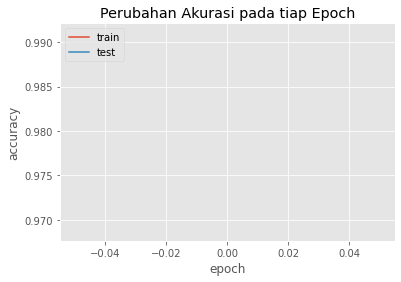

In [ ]:
# Plotting Akurasi
make_plot('accuracy', 'val_accuracy', 'Perubahan Akurasi pada tiap Epoch')

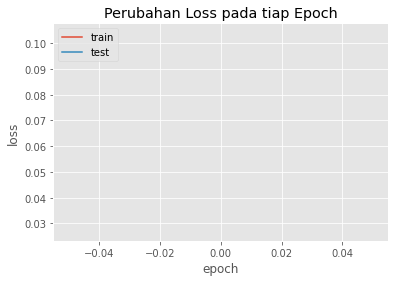

In [ ]:
# Plotting Loss
make_plot('loss', 'val_loss', 'Perubahan Loss pada tiap Epoch')

## Mengubah Model

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()


In [ ]:
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)


25252496